# CRISP-DM Analysis of AirBnB dataset of Berlin

In the following sections I will perform an Analysis of the Berlin dataset to gain some insights on the topic.


The CRISP-DM process can be broken down into several steps which help understanding the problem

1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Data Modeling
5. Evaluate the Results
6. Deploy

## Imports

Before we can start we neeed to initialize several libraries, which will be used within the project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps
import os
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from helperLibrary import *

debugdf = 0

## 1. Business Understanding

During this step of the process we define Questions that we want to answer later on. Yet this is more of an iterative process. Where new questions can arise while working with the dataset.

The questions I would like to answer are the following:

1. Which neighbourhood yields the highest returns
2. What factors have an impact on the price (ergo, when do I need to adjust the price of my listing)
3. Are there things that can be changed to increase the listing price.
4. Is it possible to predict an adequate listing price for new listings.

## 2. Data understanding

In order to answer the question curated in step one, it is necessary to obtain some sort of Data understanding. This includes a general overview of what kind of information is available within the dataset. But also where there might be potential shortcomings, such as missing data. or other pitfalls

In [2]:
# Read in the datasets
Reviews = pd.read_csv('reviews.csv')
Listings = pd.read_csv('listings.csv')
Calendar = pd.read_csv('calendar.csv')

In [3]:
# Checking out the review dataframe
if debugdf:
    Reviews.head(3)

In [4]:
# Checking out the listings dataframe
if debugdf:
    Listings.head(3)

In [5]:
# Checking out the Calendar dataframe
if debugdf:
    Calendar.head(3)

In [6]:
# Checking the shape of the datasets
if debugdf:
    print("Shape of Review dataframe:", Reviews.shape)
    print("Shape of Listings dataframe:", Listings.shape)
    print("Shape of Calendar dataframe:", Calendar.shape)

In [7]:
# Having a look at the columns
if debugdf:
    print('List of Review columns:\n\n', Reviews.columns.tolist(), '\n\n', 20*'-')
    print('List of Listings columns:\n\n', Listings.columns.tolist(), '\n\n', 20*'-')
    print('List of Calendar columns:\n\n', Calendar.columns.tolist(), '\n\n', 20*'-')



The main chunck of data is included in the listings dataframe, for this reason I will focus my analysis effort on that datafram.

In [8]:
if debugdf:
    pd.options.display.max_columns = Listings.shape[1]
    Listings.describe()

In [9]:
if debugdf:
    Listings.hist(figsize=(16,100),layout=(34,1));

In [10]:
if debugdf:
    plt.figure(figsize=(16,10))
    sns.heatmap(Listings.corr(), annot=True, fmt='.1f')

In [11]:
if debugdf:
    colinspection(Listings)

In [12]:
if debugdf:
    zerodf, somedf= splitdf(Listings)
    showmissing(somedf, 0.2)

Considering the number of columns (96) in the dataset. There are 43 columns that have no missing data, in comparison to the 48 columns, that have missing data and even 5 columns that contain only missing data. 

In [13]:
if debugdf:
    showdistribution_advanced(Listings, 'host_is_superhost')

In [14]:
if debugdf:
    Listings.neighbourhood_group_cleansed.value_counts()

In [15]:
if debugdf:
    showdistribution_advanced(Listings, 'neighbourhood_group_cleansed', percent=0)
    plt.tight_layout()
    plt.savefig('Neighboorhoods.png')

In [16]:
if debugdf:
    showdistribution_advanced(Listings, 'host_identity_verified')

In [17]:
if debugdf:
    showdistribution_advanced(Listings, 'instant_bookable')

In [18]:
if debugdf:
    showdistribution_advanced(Listings, 'room_type')

In [19]:
if debugdf:
    showdistribution_advanced(Listings, 'bedrooms')

In [20]:
if debugdf:
    showdistribution_advanced(Listings, 'minimum_nights', lower_thresh=25, upper_thresh=200, percent=False)

In [21]:
if debugdf:
    showdistribution_advanced(Listings, 'reviews_per_month', percent=False,group=True, groupbin=[0, 1, 2, 3, 4, 100])

In [22]:
if debugdf:
    showdistribution_advanced(Listings, 'reviews_per_month', lower_thresh=50, group=True, groupbin=[0,1,2,3,4,5,10])
    plt.tight_layout()
    plt.savefig('ReviewsPerMonth.png')

## 3. Prepare Data

The goal of this step is to clean up and prepare the data. This is necessary as outliers prevent further analysis using certain tools. Also is it important to justify certain choices while cleaning the data, as no method is perfect and certain drawbacks have to be considered.

Common methods used here to remove data

Drops any row with a missing value in it.
```
newdf  = df.dropna()
```

Drops only rows where all values are missing
```
newdf = df.dropna(axis=0, how='all')
```

Drops only rows where the missing value is within the subset column, in the below case its column 13. This can also be expanded by adding more columns to this list such as ['col1', 'col3']
```
newdf = small_dataset.dropna(subset=['col3'], how='any')
```


The easiest way to clean the data is to simply remove all the outliers. 

Property type seems interesing, but looking at the data I will only include apartments.

In [23]:
showoffdf = pd.DataFrame()
showoffdf['Listing_Features'] = ['id','price', 'amenities', 'number_of_reviews', 'reviews_per_month', 'property_type', 'bedrooms', 'minimum_nights',
               'review_scores_value', 'host_identity_verified', 'instant_bookable', 'host_is_superhost', 'cancellation_policy', 'room_type', 'neighbourhood_group_cleansed', 'availability_365', 'availability_90', 'availability_60', 'availability_30']

showoffdf

,Listing_Features
0,id
1,price
2,amenities
3,number_of_reviews
4,reviews_per_month
5,property_type
6,bedrooms
7,minimum_nights
8,review_scores_value
9,host_identity_verified


In [24]:
# Define a subset of the original Listing dataset
df = Listings[['id','price','number_of_reviews', 'reviews_per_month', 'property_type', 'bedrooms', 'minimum_nights',
               'review_scores_value', 'availability_365', 'availability_90', 'availability_60', 'availability_30']]
df = df[df['property_type']=='Apartment']
# After filtering out only the apartments, the column can be dropped, as it does not give us any more information.
df = df.drop(columns=['property_type'])

In [25]:
all_rm = df.dropna(axis=0)
print(df.shape)
print(all_rm.shape)
all_rm.head()

(20225, 11)
(16287, 11)


,id,price,number_of_reviews,reviews_per_month,bedrooms,minimum_nights,review_scores_value,availability_365,availability_90,availability_60,availability_30
1,2695,$17.00,6,1.42,1.0,2,10.0,0,0,0,0
2,3176,$90.00,143,1.25,1.0,62,9.0,220,0,0,0
3,3309,$26.00,25,0.39,1.0,5,9.0,297,22,0,0
4,7071,$42.00,197,1.75,1.0,2,9.0,26,26,26,15
5,9991,$180.00,6,0.15,4.0,6,10.0,137,7,7,0


### Preparing the Price column

In [26]:
all_rm['price'] = all_rm['price'].astype('str')
all_rm['price'] = all_rm['price'].apply(lambda x: x.replace('$',''))
all_rm['price'] = all_rm['price'].apply(lambda x: x.replace(',',''))
all_rm['price'] = all_rm['price'].apply(lambda x: x.replace('.00',''))
all_rm['price'] = all_rm['price'].astype('float')

all_rm.head()

/Users/dkyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/dkyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dkyun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,id,price,number_of_reviews,reviews_per_month,bedrooms,minimum_nights,review_scores_value,availability_365,availability_90,availability_60,availability_30
1,2695,17.0,6,1.42,1.0,2,10.0,0,0,0,0
2,3176,90.0,143,1.25,1.0,62,9.0,220,0,0,0
3,3309,26.0,25,0.39,1.0,5,9.0,297,22,0,0
4,7071,42.0,197,1.75,1.0,2,9.0,26,26,26,15
5,9991,180.0,6,0.15,4.0,6,10.0,137,7,7,0


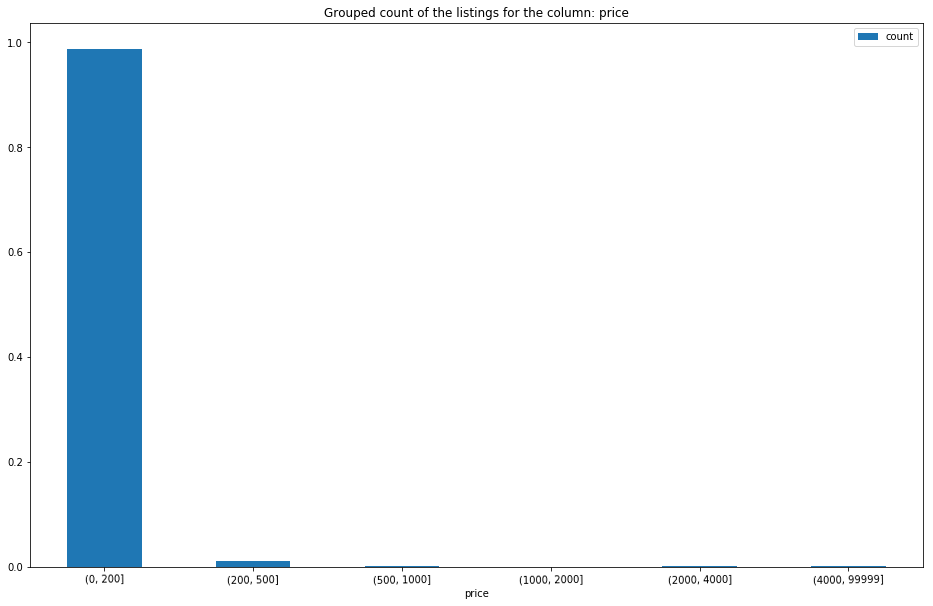

In [27]:
showdistribution_advanced(all_rm, column='price', group=True, groupbin=[0, 200, 500, 1000, 2000, 4000, 99999])

In [28]:
# Checking the dataframe for the price distrubtion, it became clear that there needs to be some 
# adjustments to be made. Looking at the diagram above I decided to remove all listings above 200 Dollars. 
all_rm[all_rm['price'] >= 200].shape
all_rm = all_rm[all_rm['price'] <= 200]

### Prepare some boolean data

In [29]:
boolean_feature = ['host_identity_verified', 'instant_bookable', 'host_is_superhost']
for i in boolean_feature:
    all_rm[i] = Listings[i].map(lambda x: True if x=='t' else False)
all_rm.head()

,id,price,number_of_reviews,reviews_per_month,bedrooms,minimum_nights,review_scores_value,availability_365,availability_90,availability_60,availability_30,host_identity_verified,instant_bookable,host_is_superhost
1,2695,17.0,6,1.42,1.0,2,10.0,0,0,0,0,True,False,False
2,3176,90.0,143,1.25,1.0,62,9.0,220,0,0,0,True,True,False
3,3309,26.0,25,0.39,1.0,5,9.0,297,22,0,0,True,False,False
4,7071,42.0,197,1.75,1.0,2,9.0,26,26,26,15,True,False,True
5,9991,180.0,6,0.15,4.0,6,10.0,137,7,7,0,True,False,False


### Prepare cancellation policy

In [30]:
all_rm = pd.concat([all_rm, pd.get_dummies(Listings['cancellation_policy'])],axis=1)
all_rm.head()

,id,price,number_of_reviews,reviews_per_month,bedrooms,minimum_nights,review_scores_value,availability_365,availability_90,availability_60,availability_30,host_identity_verified,instant_bookable,host_is_superhost,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0
1,2695.0,17.0,6.0,1.42,1.0,2.0,10.0,0.0,0.0,0.0,0.0,True,False,False,1,0,0,0,0
2,3176.0,90.0,143.0,1.25,1.0,62.0,9.0,220.0,0.0,0.0,0.0,True,True,False,0,0,1,0,0
3,3309.0,26.0,25.0,0.39,1.0,5.0,9.0,297.0,22.0,0.0,0.0,True,False,False,0,0,1,0,0
4,7071.0,42.0,197.0,1.75,1.0,2.0,9.0,26.0,26.0,26.0,15.0,True,False,True,0,1,0,0,0


### Preparing the room type data

In [31]:
all_rm = pd.concat([all_rm, pd.get_dummies(Listings['room_type'])],axis=1)

In [32]:
all_rm.head()

,id,price,number_of_reviews,reviews_per_month,bedrooms,minimum_nights,review_scores_value,availability_365,availability_90,availability_60,...,instant_bookable,host_is_superhost,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60,Entire home/apt,Private room,Shared room
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,1,0,0,1,0,0
1,2695.0,17.0,6.0,1.42,1.0,2.0,10.0,0.0,0.0,0.0,...,False,False,1,0,0,0,0,0,1,0
2,3176.0,90.0,143.0,1.25,1.0,62.0,9.0,220.0,0.0,0.0,...,True,False,0,0,1,0,0,1,0,0
3,3309.0,26.0,25.0,0.39,1.0,5.0,9.0,297.0,22.0,0.0,...,False,False,0,0,1,0,0,0,1,0
4,7071.0,42.0,197.0,1.75,1.0,2.0,9.0,26.0,26.0,26.0,...,False,True,0,1,0,0,0,0,1,0


### Preparing the neigbourhood data

In [33]:
all_rm = pd.concat([all_rm, pd.get_dummies(Listings['neighbourhood_group_cleansed'])],axis=1)

In [34]:
print(all_rm.shape)
all_rm.head()

(22552, 34)


,id,price,number_of_reviews,reviews_per_month,bedrooms,minimum_nights,review_scores_value,availability_365,availability_90,availability_60,...,Lichtenberg,Marzahn - Hellersdorf,Mitte,Neukölln,Pankow,Reinickendorf,Spandau,Steglitz - Zehlendorf,Tempelhof - Schöneberg,Treptow - Köpenick
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
1,2695.0,17.0,6.0,1.42,1.0,2.0,10.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,3176.0,90.0,143.0,1.25,1.0,62.0,9.0,220.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,3309.0,26.0,25.0,0.39,1.0,5.0,9.0,297.0,22.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,7071.0,42.0,197.0,1.75,1.0,2.0,9.0,26.0,26.0,26.0,...,0,0,0,0,1,0,0,0,0,0


### Preparing the amenities data

In [35]:
tempdf = Listings.copy()
tempdf['amenities'] = tempdf['amenities'].map(lambda x: x.replace('"','').replace('{','').replace('}','').split(','))
unique_amenities = np.unique(np.concatenate(tempdf['amenities'].values))
amenities_array = np.array([tempdf['amenities'].map(lambda x: i in x) for i in unique_amenities])
amenities_array_t = amenities_array.T
amenities_df = pd.DataFrame(data=amenities_array_t, columns=unique_amenities)
amenities_df.head()

,,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,...,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower,Wide doorway,Wide entryway,Wide hallway clearance,Wifi,Window guards,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True


In [36]:
# The data had some outliers, which I quickly dropped
amenities_df.drop(amenities_df.columns[[0, 134, 135]],axis=1,inplace=True)
amenities_df.head()


,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,...,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower,Wide doorway,Wide entryway,Wide hallway clearance,Wifi,Window guards
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [37]:
features = pd.concat([all_rm, amenities_df], axis=1)
print(features.shape)
features = features.dropna(axis=0)
print(features.shape)


(22552, 167)
(16093, 167)


In [38]:
features_calendar = features.copy()
features.drop(features.columns[[0]],axis=1,inplace=True)
features.shape
features.head()

,price,number_of_reviews,reviews_per_month,bedrooms,minimum_nights,review_scores_value,availability_365,availability_90,availability_60,availability_30,...,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to bed,Wide clearance to shower,Wide doorway,Wide entryway,Wide hallway clearance,Wifi,Window guards
1,17.0,6.0,1.42,1.0,2.0,10.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,90.0,143.0,1.25,1.0,62.0,9.0,220.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
3,26.0,25.0,0.39,1.0,5.0,9.0,297.0,22.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,42.0,197.0,1.75,1.0,2.0,9.0,26.0,26.0,26.0,15.0,...,False,False,False,False,False,False,False,False,True,False
5,180.0,6.0,0.15,4.0,6.0,10.0,137.0,7.0,7.0,0.0,...,False,False,False,False,False,False,False,False,True,False


In [39]:
if debugdf:
    showdistribution_advanced(features, 'price', group=True, groupbin=[0,125,200])
    plt.tight_layout()
    plt.savefig('Price_distribution.png')

## 4. Data Modeling

In [40]:
X = features.drop('price', axis=1)
y = features['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=2
)

# Instantiate
lm_model = LinearRegression()

# Fit the model
lm_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
predicted_train_price = lm_model.predict(X_test)

In [42]:
r2_test = r2_score(y_test, predicted_train_price)
r2_test

0.49986188685331767

In [43]:
mse = mean_squared_error(y_test, predicted_train_price)
mse

481.8104956392351

In [44]:
root_mse = mse**(1/2)
root_mse

21.95018213225656

In [45]:
coefs = list(zip(lm_model.coef_, features))
coefs.sort(reverse=True)
coefs

[(29.144960234249112, 'Iron'),
 (22.90668283667215, 'Lock on bedroom door'),
 (21.54670188629926, 'Smart TV'),
 (20.982185624370025, 'Breakfast table'),
 (18.021102074336508, 'super_strict_60'),
 (15.67317717951684, 'reviews_per_month'),
 (14.682889112193283, 'Garden or backyard'),
 (13.182807823151824, 'Pocket wifi'),
 (11.050172145977339, 'moderate'),
 (9.494111108922253, 'Accessible-height toilet'),
 (8.359020537505781, 'Free street parking'),
 (8.171321255815018, 'Charlottenburg-Wilm.'),
 (8.122253951948828, 'Marzahn - Hellersdorf'),
 (7.91577596032611, 'flexible'),
 (7.787080731685748, 'TV'),
 (7.698022140479594, 'Fire extinguisher'),
 (6.865141795948995, 'Shampoo'),
 (6.487202848949271, 'host_is_superhost'),
 (6.091283632746387, 'Neukölln'),
 (5.634211351587148, 'Cat(s)'),
 (5.379771281827742, 'Ceiling hoist'),
 (5.005606920121167, 'Suitable for events'),
 (4.916293127507203, 'Heating'),
 (4.852297997752895, 'Doorman'),
 (4.820453074124553, 'Hot water kettle'),
 (4.79656022233222

In [46]:
neighborhoods = np.unique(Listings['neighbourhood_group_cleansed'])
neighborhood_impact = [i for i in coefs if i[1] in neighborhoods]
neighborhood_impact.sort(reverse=True)

In [47]:
for index, val in neighborhood_impact:
    print(index, val)

8.171321255815018 Charlottenburg-Wilm.
8.122253951948828 Marzahn - Hellersdorf
6.091283632746387 Neukölln
3.983742307465901 Mitte
2.037639886541861 Steglitz - Zehlendorf
-0.1750613379136282 Treptow - Köpenick
-0.45707464178325236 Friedrichshain-Kreuzberg
-2.473379020264995 Tempelhof - Schöneberg
-4.659847094027508 Spandau
-5.651333347294033 Pankow
-7.691168634229697 Lichtenberg
-8.62006259891956 Reinickendorf


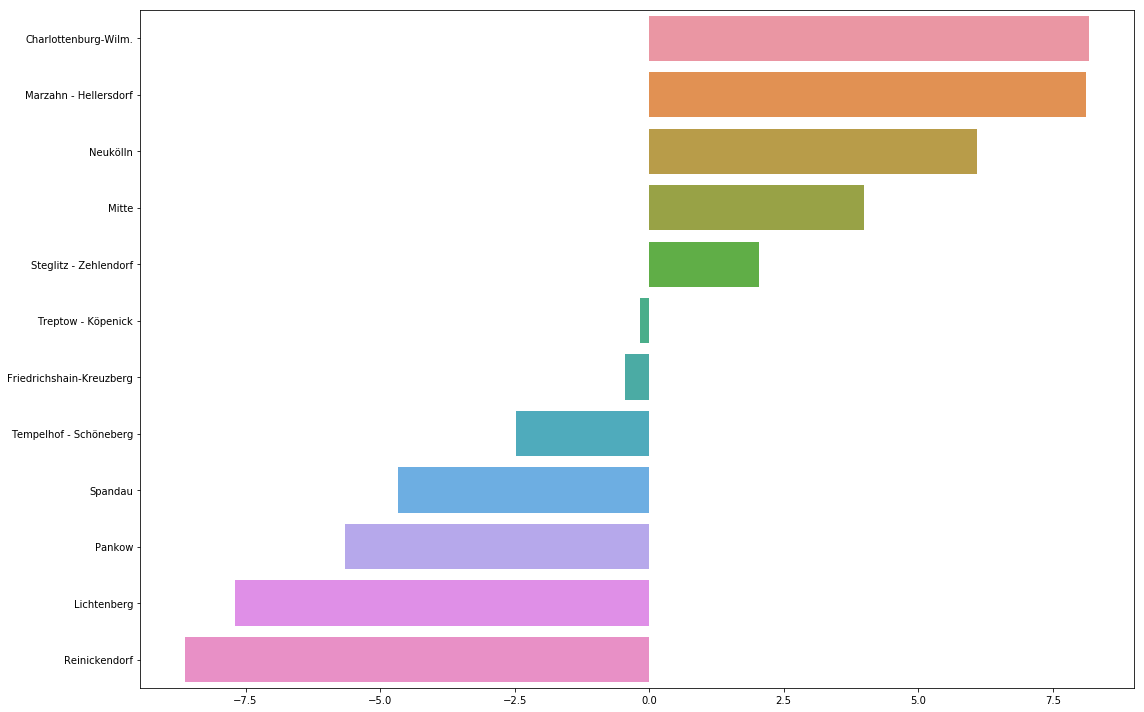

In [48]:
plt.figure(figsize=(16,10))
sns.barplot(x=[n[0] for n in neighborhood_impact], y=[n[1] for n in neighborhood_impact], orient='h')
plt.tight_layout()
plt.savefig('neighboorhoods.png')

In [49]:
amenity_impact = [i for i in coefs if i[1] in unique_amenities]
amenity_impact.sort(reverse=True)
amenity_impact


[(29.144960234249112, 'Iron'),
 (22.90668283667215, 'Lock on bedroom door'),
 (21.54670188629926, 'Smart TV'),
 (20.982185624370025, 'Breakfast table'),
 (14.682889112193283, 'Garden or backyard'),
 (13.182807823151824, 'Pocket wifi'),
 (9.494111108922253, 'Accessible-height toilet'),
 (8.359020537505781, 'Free street parking'),
 (7.787080731685748, 'TV'),
 (7.698022140479594, 'Fire extinguisher'),
 (6.865141795948995, 'Shampoo'),
 (5.634211351587148, 'Cat(s)'),
 (5.379771281827742, 'Ceiling hoist'),
 (5.005606920121167, 'Suitable for events'),
 (4.916293127507203, 'Heating'),
 (4.852297997752895, 'Doorman'),
 (4.820453074124553, 'Hot water kettle'),
 (4.796560222332227, 'Electric profiling bed'),
 (4.732955795501173, 'Pack ’n Play/travel crib'),
 (4.5813501855178975, 'Children’s books and toys'),
 (4.191154650767039, 'Step-free access'),
 (4.036056569458637, 'Wide hallway clearance'),
 (3.6258994953352452, 'Cooking basics'),
 (3.5750033050884893, 'Baby bath'),
 (3.3302926624082274, 'B

In [50]:
cleaned = [x for x in amenity_impact if x[0] < -8 or x[0] >10]
cleaned

[(29.144960234249112, 'Iron'),
 (22.90668283667215, 'Lock on bedroom door'),
 (21.54670188629926, 'Smart TV'),
 (20.982185624370025, 'Breakfast table'),
 (14.682889112193283, 'Garden or backyard'),
 (13.182807823151824, 'Pocket wifi'),
 (-8.538490737394525, 'EV charger'),
 (-8.806404655666437, 'Sound system'),
 (-16.496585228098372, 'Fireplace guards'),
 (-18.61531059229498, 'Beach essentials'),
 (-20.55455004575192, 'Safety card')]

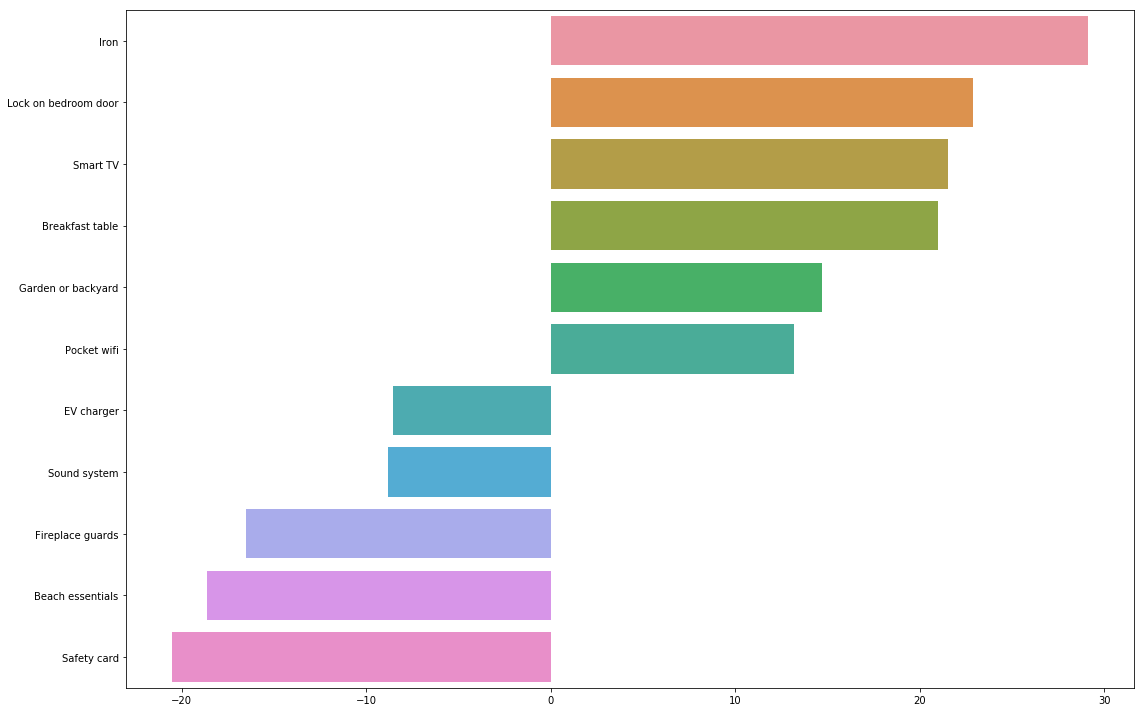

In [51]:
plt.figure(figsize=(16,10))
sns.barplot(x=[n[0] for n in cleaned], y=[n[1] for n in cleaned], orient='h')
plt.tight_layout()
plt.savefig('amenities.png')

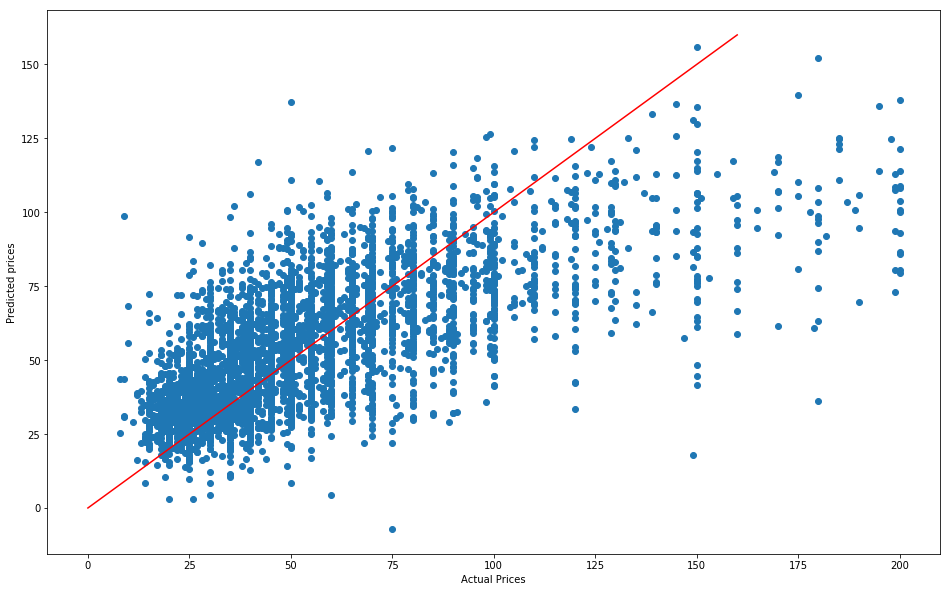

In [52]:
plt.figure(figsize=(16,10))
plt.scatter(y_test, predicted_train_price)
plt.plot([0, 160], [0, 160], 'r-' )
plt.ylabel('Predicted prices')
plt.xlabel('Actual Prices')
plt.savefig('r2_plot.png')

# Determine the average price for a specific date

In [53]:
Calendar.head()


,listing_id,date,available,price
0,2015,2019-09-10,f,NaN
1,2015,2019-09-09,f,NaN
2,2015,2019-09-08,f,NaN
3,2015,2019-09-07,f,NaN
4,2015,2019-09-06,f,NaN


In [54]:
Calendar.shape

(8231480, 4)

In [55]:
df = pd.DataFrame()
tempdf['date'] = pd.to_datetime(Calendar['date'])
df['year'] = tempdf['date'].dt.year
df['month'] = tempdf['date'].dt.month
df['day'] = tempdf['date'].dt.day
dfCalendar = pd.concat([df, Calendar[['listing_id', 'available', 'price']]],axis=1)

In [56]:
dfCalendar.head()

,year,month,day,listing_id,available,price
0,2019.0,9.0,10.0,2015,f,NaN
1,2019.0,9.0,9.0,2015,f,NaN
2,2019.0,9.0,8.0,2015,f,NaN
3,2019.0,9.0,7.0,2015,f,NaN
4,2019.0,9.0,6.0,2015,f,NaN


In [57]:
dfCalendar['price'] = dfCalendar.loc[:,('price')].astype('str')
dfCalendar['price'] = dfCalendar.loc[:,('price')].apply(lambda x: x.replace('$',''))
dfCalendar['price'] = dfCalendar.loc[:,('price')].apply(lambda x: x.replace(',',''))
dfCalendar['price'] = dfCalendar.loc[:,('price')].astype('float')
dfCalendar_rm = dfCalendar.dropna()


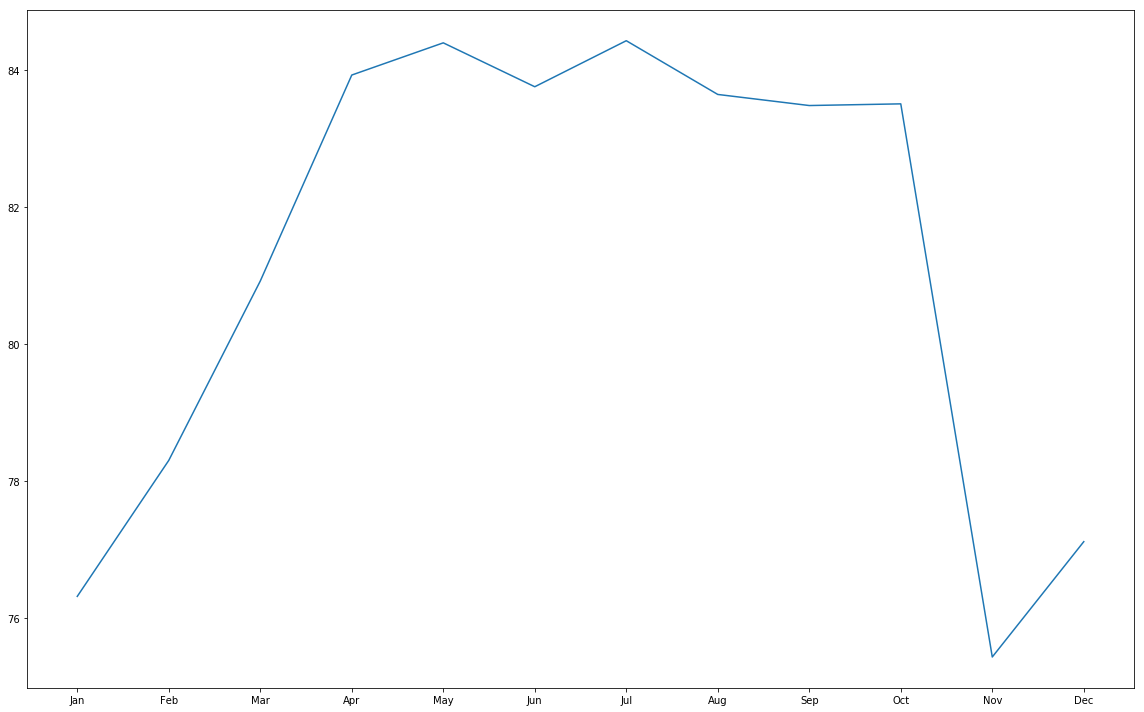

In [58]:
plt.figure(figsize=(16,10))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# sns.boxenplot(x="month", y="price", data=dfCalendar_rm)
plt.plot(dfCalendar_rm[['month','price']].groupby('month').mean())
plt.xticks(np.arange(1, 13, step=1), months);
plt.tight_layout()
plt.savefig('PriceTime.png')

## 5 & 6 Evaluation and deployment

The final evaluation can be found in Medium under the following link
